# "Wait, how do embeddings work?"
> "No NLP, no word2vec, just categorical embeddings in NumPy."
- toc: true
- image: ../images/2020-05-14-embeddings/log_reg/log_reg.gif
- branch: master
- badges: true
- comments: true
- categories: [data science]
- hide: false
- search_exclude: false

In [1]:
#collapse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

Recently, someone asked me to remind them how [categorical embeddings](https://www.fast.ai/2018/04/29/categorical-embeddings/) work. I began to explain how I thought them, and the mechanics of "training" embeddings, but the look on my counterpart's face was enough to let me know that I didn't understand them as well as I thought I did. After our conversation, I turned to the internet to try to sharpen my understanding about some of the fuzzy aspects of embeddings, but found that most resources were either dense with [NLP jargon](https://dev.to/tomerbendavid/nlp-terminology-in-5-minutes-3mdd), or specific to [Word2vec](http://jalammar.github.io/illustrated-word2vec/). Both topics are certainly worth studying, but stood in the way of me grasping the fundamentals of embeddings.

I resonate with the sentiment Richard Feynman evokes in his famous quote,

> _"What I cannot create, I do not understand."_

so naturally, I set out to boil categorical embeddings down to the simplest case, and implement them myself. This post will cover the subtle details of training embeddings on a toy example, using `NumPy`. I imagine this will be most helpful to individuals who know a bit about embeddings, or perhaps have even used them with [PyTorch](https://pytorch.org/docs/stable/nn.html#embedding) or [Keras](https://keras.io/api/layers/core_layers/embedding/), but haven't themselves delved into the nuances. My intent here is to cut through the noise and zero in on _exactly_ what it means to "train embeddings" (spoiler: you don't need to be doing NLP to leverage them).

The code below is optimized for simplicity and readability, _not_ for algorithmic efficiency. In other words, get ready for some for-loops.

# Logistic Regression from scratch

In the spirit of Feynman, let's build this from the ground up. We'll start with simple Logistic Regression, then add embeddings in the next section. 

Assume that we are interested in training a binary classifier on this toy dataset below.

In [2]:
#collapse

# initializing dataset
obs1 = [-1]
obs2 = [3]
obs3 = [-2]
obs4 = [4]
X = np.array([obs1, obs2, obs3, obs4])
y = np.array([[0], [1], [0], [1]])

# initializing logistic regression parameter
w = np.array([[-0.75]])   

# wrapping in pd.DataFrame for nice printing
pd.DataFrame(np.hstack([X, y]), columns=["x", "y"])

,x,y
0,-1,0
1,3,1
2,-2,0
3,4,1


From a quick glance, it appears that observations from class `0` tend to have negative values, and observations from class `1` tend to have positive values. This dataset should be easy to classify. Now, let's put together a few functions to perform logistic regression.

{% include info.html text="Note: I won't be covering the log-likelihood function's details, but the inclined reader can find its derivation in the docstring below." %}

In [4]:
#collapse_show

def sigmoid(z):
    """
    https://en.wikipedia.org/wiki/Sigmoid_function
    """
    return 1 / (1 + np.exp(-z))

def predict_proba(X, w):
    """
    Mimics Scikit-Learn's .predict_proba() method.
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba
    """
    return sigmoid(np.dot(X, w))

def nll(y, y_hat):
    """
    This calculates the negative log likelihood of the data,
    which is the loss functions we'll minimize.
    https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/pdfs/40%20LogisticRegression.pdf
    """
    m = y.shape[0]
    loss = -(1/m) * ((y*np.log(y_hat)) + ((1-y)*np.log(1-y_hat))).sum()
    return loss

def nll_gradient(X, y, w):
    """
    This calculates the gradient of the negative log likelihood
    function. (specifically, with respect to the weights)
    """
    m = y.shape[0]
    gradient = -(1/m) * ((y - predict_proba(X, w)) * X).sum()
    return np.array([[gradient]])

In [5]:
#hide
def gradient_checker(grad_func, loss_func, X, y, w, epsilon=1e-4):
    """
    http://deeplearning.stanford.edu/tutorial/supervised/DebuggingGradientChecking/
    """
    grad = grad_func(X, y, w)
    loss_plus_epsilon = loss_func(y, predict_proba(X, w+epsilon))
    loss_minus_epsilon = loss_func(y, predict_proba(X, w-epsilon))
    grad_approx = (loss_plus_epsilon - loss_minus_epsilon) / 2*epsilon
    print(grad.item(), grad_approx)

gradient_checker(nll_gradient, nll, X, y, w)

-2.209643941038771 -2.2096439388152867e-08


Above, the `sigmoid(z)` function is an inherent piece of the Logistic Regression model. In addition, the `predict_proba(X, w)` function mimic's Scikit-Learn's [`.predict_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) functionality, using the data, `X`, and the learned weight, `w`, to predict the target, `y`. Finally, the `nll(y, y_hat)` and `nll_gradient(X, y, w)` functions compute the loss associated with our model and the gradient of that loss, respectively, which are used to update our weight, `w`.

In [6]:
#collapse

def plot_decision_boundary(X, y, w, epoch=0, loss=0, save=False, file_path="../images/2020-05-14-embeddings/log_reg/", show=False):
    x = np.linspace(-10, 10).reshape(-1, 1)
    pred_line = predict_proba(x, w)
    
    # plot formatting
    plt.plot(x, pred_line, linewidth=3, c='cornflowerblue')
    plt.scatter(X, y, c=["khaki", "tab:green"]*2, edgecolors="black", s=100)
    plt.axhline(0.5, -10, 10, c='firebrick', linestyle="dashed")
    plt.text(4, 0.54, "probability = 0.5", c='firebrick')
    plt.grid()
    plt.title(f"Epoch {epoch+1}, loss: {round(loss, 4)}")
    plt.xlabel("x", fontsize=14)
    plt.ylabel("y", fontsize=14)
    class_0 = mpatches.Patch(color="khaki", label="class 0")
    class_1 = mpatches.Patch(color="tab:green", label="class 1")
    plt.legend(handles=[class_0, class_1])
    
    # saving/showing fig
    if save:
        plt.savefig(file_path + f"{epoch+1}.png")
    if show:
        plt.show()
    plt.clf()
    

def save_gif(file_path="../images/2020-05-14-embeddings/log_reg/", epochs=10):
    images = [Image.open(file_path + f"{epoch+1}.png") for epoch in range(epochs)]
    images[0].save(file_path + "log_reg.gif", save_all=True, append_images=[im for im in images], optimize=False, duration=300, loop=0)

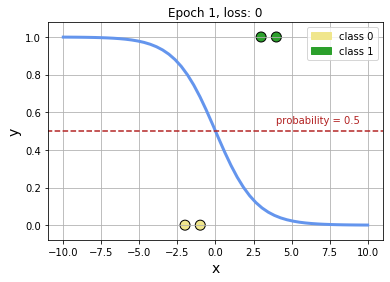

<Figure size 432x288 with 0 Axes>

In [10]:
#hide
plot_decision_boundary(X, y, w, show=True)

With these functions, we can then proceed with our training loop, which will use [vanilla gradient descent](https://ruder.io/optimizing-gradient-descent/) to find the optimal weight, `w`, which minimizes the negative log likelihood function.

In [11]:
def training_loop(X, y, w, learning_rate=0.1, epochs=20, verbose=True):
    for i in range(epochs):
        y_hat = predict_proba(X, w)
        loss = nll(y, y_hat)
        w = w - (learning_rate * nll_gradient(X, y, w))
        plot_decision_boundary(X, y, w, epoch=i, loss=loss, save=True)
        if verbose:
            if i % 5 == 0:
                print(f"epoch {i} loss: {round(loss, 4)}")
    save_gif(epochs=epochs)
    return w

In [12]:
w_optimal = training_loop(X, y, w, epochs=40)

epoch 0 loss: 2.0593
epoch 5 loss: 0.5455
epoch 10 loss: 0.278
epoch 15 loss: 0.1981
epoch 20 loss: 0.1588
epoch 25 loss: 0.1349
epoch 30 loss: 0.1185
epoch 35 loss: 0.1064


<Figure size 432x288 with 0 Axes>

As we can see by the strcitly decreasing loss of our model, printed every 5 iterations, it appears that our model has converged to its optimum! Perhaps more compelling, however, is to visually see how the decisioun boundary changed across each iteration.

![log_reg](../images/2020-05-14-embeddings/log_reg/log_reg.gif)

# Adding Embeddings

Now that we've got a handle on Logistic Regression, let's add some embeddings to the mix. Suppose, for example, that we extend our toy dataset to also include a categorical variable.

| category | $x_1$ | $y$ |
|----------|-------|---|
| A        | -1    | 0 |
| B        | 3     | 1 |
| C        | -2    | 0 |
| D        | 4     | 1 |

Given that each datapoint reigns from a different category, we may not be able to get much predictive power out of this new categorical variable, however, we can leverage embeddings to express the relationship between these categories, with respect to their target, `y`, in a higher-dimensional, continuous space (as opposed to the one-dimensional, discrete space that they exist in currently).

The first step towards using embeddings in this manner is to substitute each unique category in the dataset with a unique `n` dimensional vector (in this case, `n==2`). We simply intialize them as zeros.

| $e_1$ | $e_2$ | $x_1$ | $y$ |
|-------|-------|-------|---|
| 0     | 0     | -1    | 0 |
| 0     | 0     | 3     | 1 |
| 0     | 0     | -2    | 0 |
| 0     | 0     | 4     | 1 |

To be precise, $e_1$ represents the first dimension of categorical embedding, and $e_2$ represents the second dimension, while $x_1$ is the same numeric variable that we had in our example above.

In [13]:
#collapse

# initializing dataset
obs1 = [0, 0] + [-1]
obs2 = [0, 0] + [3]
obs3 = [0, 0] + [-2]
obs4 = [0, 0] + [4]
X = np.array([obs1, obs2, obs3, obs4])
y = np.array([[0], [1], [0], [1]])

# initializing log reg parameters
w = np.array([[0.5],
              [-0.25],
              [-0.75]])

# pd.DataFrame(np.hstack([X, y]), columns=["e_1", "e_2", "x_3", "y"])

Then, you can train a logistic regression model to classify the data points as normal, treating $e_1$ and $e_2$ as features in the dataset. The only difference is that now instead of just updating the weights on each gradient descent loop, you also update the embeddings (this is somewhat counterintuitive, as we're essentially changing the data). The update rules are:

$$
\begin{aligned}
    w &\leftarrow w - \alpha \cdot \frac{\partial \text{ loss function}}{\partial\ w}\\
    e_1 &\leftarrow e_1 - \alpha \cdot \frac{\partial \text{ loss function}}{\partial\ e_1}\\
    e_2 &\leftarrow e_2 - \alpha \cdot \frac{\partial \text{ loss function}}{\partial\ e_2}
\end{aligned}
$$

As the parameters are updated, embeddings for categories with similar characteristics remain close to each other in the new 2-dimensional space we've mapped them to. In the gif below, notice how the embeddings for categories A and C stay close to each other, as well as B and D.

In [33]:
w.shape

(3, 1)

In [34]:
def nll_gradient_weights(X, y, w):
    """
    returns deriv of log loss w/ respect to w
    """
    m = X.shape[0]
    return (-(1/m) * ((y - predict_proba(X, w)) * X).sum(axis=0)).reshape(-1, 1)

In [35]:
nll_gradient_weights(X, y, w)

array([[-0.        ],
       [-0.        ],
       [-2.20964394]])

In [36]:
def nll_gradient_embeddings(X, y, w, n_embeddings=4, emb_size=2):
    """
    returns deriv of log loss w/ respect to each embedding
    assumes embeddings come at beginning of each row
    """
    m = X.shape[0]
    embedding_derivatives = []
    for i in range(m):
        embed_i_derivs = []
        for j in range(emb_size):
            derivative = (-(1/1) * ((y[i, :] - predict_proba(X[i, :], w)) * w[j, :])).item()
            embed_i_derivs.append(derivative)
        embedding_derivatives.append(embed_i_derivs)
        
    return np.array(embedding_derivatives)

In [37]:
nll_gradient_embeddings(X, y, w)

array([[ 0.33958935, -0.16979467],
       [-0.45232527,  0.22616263],
       [ 0.40878724, -0.20439362],
       [-0.47628706,  0.23814353]])

In [38]:
def plot_decision_boundary_embeddings(X, y, w, epoch=0, loss=0, save=False, show=False):
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    categories = ["A", "B", "C", "D"]
    alpha = 0.8
    s = 100
    
    # log reg decision boundary
    x = np.linspace(-10, 10).reshape(-1, 1)
    pred_line = predict_proba(x, w[2:, :])
    ax[0].plot(x, pred_line, linewidth=3, c='black')
    ax[0].scatter(X[:, 2:], y, c=colors, edgecolors="black", s=s, alpha=alpha)
    ax[0].axhline(0.5, -10, 10, c='firebrick', linestyle="dotted")
    ax[0].text(4, 0.54, "probability = 0.5", c='firebrick')
    ax[0].grid()
    
    # labels
    ax[0].set_title(f"Impact of x_1 on decision boundary", fontsize=16)
    ax[0].set(xlabel="x_1", ylabel="y")
    ax[0].xaxis.get_label().set_fontsize(14)
    ax[0].yaxis.get_label().set_fontsize(14)
    
    # set legend
    handles = []
    for i, (color, category) in enumerate(zip(colors, categories)):
        handles.append(mpatches.Patch(color=color, label=f"cat {category}", alpha=alpha))
    ax[0].legend(handles=handles)
    
    
    # embeddings plot
    embeddings = X[:, :2]
    ax[1].set_xlim(-1, 0.5)
    ax[1].set_ylim(-0.5, 0.75)
    for i, (color, category) in enumerate(zip(colors, categories)):
        ax[1].scatter(X[i, 0], X[i, 1], label=f"cat {category}", alpha=alpha, s=s, edgecolors="black", c=color)
    for i, (color, category) in enumerate(zip(colors, categories)):
        ymin, ymax = ax[1].get_ylim()
        xmin, xmax = ax[1].get_xlim()
        ax[1].axvline(x=X[i, 0], ymin=0, ymax=(X[i, 1]-ymin) / (ymax-ymin), alpha=alpha, c=color, linestyle="dashed")
        ax[1].axhline(y=X[i, 1], xmin=0, xmax=(X[i, 0]-xmin) / (xmax-xmin), alpha=alpha, c=color, linestyle="dashed")
    ax[1].legend()
    ax[1].grid()
    
    # labels
    ax[1].set_title(f"Embeddings", fontsize=16)
    ax[1].set(xlabel="embedding dimension 1", ylabel="embedding dimension 2")
    ax[1].xaxis.get_label().set_fontsize(14)
    ax[1].yaxis.get_label().set_fontsize(14)
    
    
    # fig-wide settings
    fig.suptitle(f"Epoch: {epoch+1}, Log loss: {round(loss, 4)}", fontsize=18)
    
    
    if save:
        plt.savefig(f"embeddings_images/embeddings/log_reg_{epoch+1}.png")
    if show:
        plt.show()
    plt.clf()

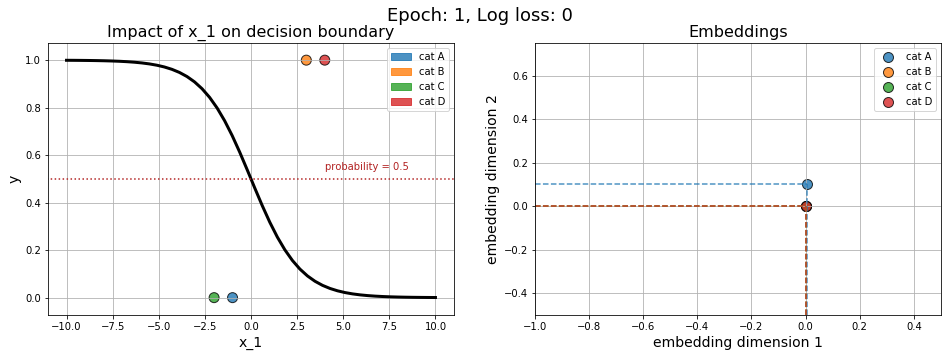

<Figure size 432x288 with 0 Axes>

In [39]:
obs1 = [0.005, 0.1] + [-1]
obs2 = [0, 0] + [3]
obs3 = [0, 0] + [-2]
obs4 = [0, 0] + [4]
test_X = np.array([obs1, obs2, obs3, obs4])
plot_decision_boundary_embeddings(test_X, y, w, epoch=0, loss=0, save=False, show=True)

In [759]:
def training_loop_embeddings(X, y, w, learning_rate=0.1, epochs=20, verbose=True):
    for i in range(epochs):
        y_hat = predict_proba(X, w)
        loss = nll(y, y_hat)

        # calculate new weights
        new_weights = w - (learning_rate * nll_gradient_weights(X, y, w))
        # calculate new embeddings
        new_embeddings = X[:, :2] - (learning_rate * nll_gradient_embeddings(X, y, w))

        # update weights and embeddings
        w = new_weights
        X = np.hstack([new_embeddings, X[:, 2:]])
        
        plot_decision_boundary_embeddings(X, y, w, epoch=i, loss=loss, save=True)
        if verbose:
            if i % 5 == 0:
                print(f"epoch {i} loss: {round(loss, 4)}")
    return X, w

In [760]:
X_updated, w_optimal = training_loop_embeddings(X, y, w, epochs=40)

epoch 0 loss: 2.0593
epoch 5 loss: 0.5128
epoch 10 loss: 0.2534
epoch 15 loss: 0.1744


/Users/collinprather/anaconda3/envs/orioles/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


epoch 20 loss: 0.1347
epoch 25 loss: 0.11
epoch 30 loss: 0.093
epoch 35 loss: 0.0803


<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

In [761]:
images = [Image.open(f"embeddings_images/embeddings/log_reg_{epoch+1}.png") for epoch in range(40)]
images[0].save('embeddings_images/embeddings/log_reg.gif', save_all=True, append_images=[im for im in images], optimize=False, duration=300, loop=0)

# Resume here!!

generate gif that shows decision boundary and embeddings being updated on each iteration.

below here is old

Text(0, 0.5, 'dimension 2')

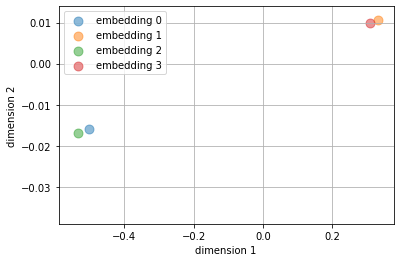

In [459]:
embeddings = X[:, :2]
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i, 1], label=f"embedding {i}", alpha=0.5, s=80)
plt.legend()
plt.grid()
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")

In [116]:
X[:, :2]

array([[-0.31536751, -0.95955474],
       [ 0.11569633,  0.42461473],
       [-0.34411421, -1.03671392],
       [ 0.10044862,  0.38136084]])

Notice, there is no direct interpretation of the units on the x and y axis. We can tell, however, that in this two dimensional space, the embeddings for category 1 and category 2 are very similar.

Make a note about how if I keep training, they land right on top of each other!

Note in practice, people typically train, 50, 100, 250 dimensional embeddings.